# 分析CPU处于不同环境中的影响因素

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False 

mach=pd.read_csv('mach.csv')
cpu=pd.read_csv('CPU.csv')
train=pd.read_csv('test.csv')
train=train.merge(mach,on=['machid'],how='left')
train=train.merge(cpu,on=['cpuid'],how='left')

In [24]:
train['Benchmark'].value_counts()

CINT2017rate    7962
CFP2017rate     7685
CINT2017        6175
CFP2017         6046
Name: Benchmark, dtype: int64

In [25]:
train=train[(train['BaseResult']!=0)&(train['BaseResult'].isnull()==False)]
train['BaseResult']=train['BaseResult']/train['Chips']
t1=train[['Processor','Benchmark','BaseResult']].groupby(['Processor','Benchmark']).agg(max).reset_index().rename(columns={'BaseResult':'max'})
t2=train[['Processor','Benchmark','BaseResult']].groupby(['Processor','Benchmark']).agg(min).reset_index().rename(columns={'BaseResult':'min'})
train=train.merge(t1,on=['Processor','Benchmark'],how='left')
train=train.merge(t2,on=['Processor','Benchmark'],how='left')
train['score']=(train['BaseResult']-train['min'])/(train['max']-train['min'])

In [26]:
train.loc[train['max']==train['min'],'score']=1
train['score'].describe()

count    27832.000000
mean         0.493203
std          0.317381
min          0.000000
25%          0.222222
50%          0.482353
75%          0.764706
max          1.000000
Name: score, dtype: float64

In [48]:
feat_cols=['Vendor', 'Cores', 'Chips', 'MemoSize(GB)', 'MemoNum', 'DiskSize(TB)', 
        'OS', 'KernelVersion', 'FileSystem','FC', 'FV', 'CC', 'CV', 'C++C', 'C++V']
X=train[feat_cols]
y=train['score']
raw=X.copy()

In [49]:
from sklearn import preprocessing
for col  in [ 'Vendor', 'MemoNum', 
        'OS', 'KernelVersion', 'FileSystem','FC', 'FV', 'CC', 'CV', 'C++C', 'C++V']:
    le = preprocessing.LabelEncoder()
    le.fit(X[col])
    X[col]=le.transform(X[col])
    
#le.inverse_transform([0, 0, 1, 2])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [50]:
import shap
import xgboost
shap.initjs()  # notebook环境下，加载用于可视化的JS代码

model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

In [53]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)  # 传入特征矩阵X，计算SHAP值
shap.force_plot(explainer.expected_value, shap_values[3,:], raw.iloc[3,:])

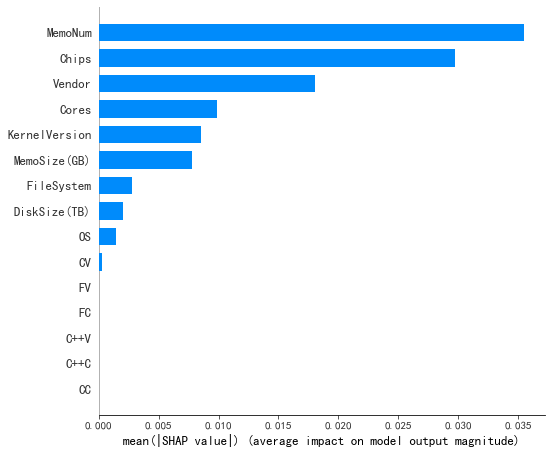

In [54]:
shap.summary_plot(shap_values, X, plot_type="bar")

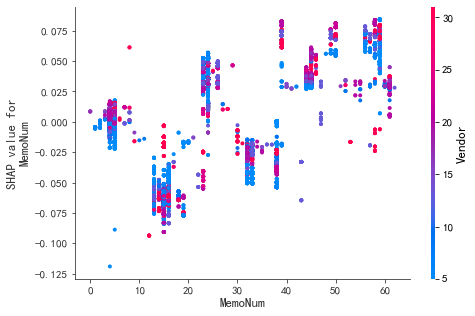

In [55]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("MemoNum", shap_values, X)

# 预测跑分

In [56]:
import pandas as pd
import numpy as np
mach=pd.read_csv('mach.csv')
cpu=pd.read_csv('CPU.csv')
train=pd.read_csv('test.csv')
train=train.merge(mach,on=['machid'],how='left')
train=train.merge(cpu,on=['cpuid'],how='left')

In [58]:
train.columns

Index(['Benchmark', 'machid', 'testid', 'HW Avail', 'SW Avail', 'License',
       'TestedBy', 'TestSponsor', 'TestDate', 'Published', 'Updated',
       'PeakResult', 'BaseResult', 'EnergyPeakResult', 'EnergyBaseResult',
       '531.deepsjeng_r', '600.perlbench_s', '625.x264_s', '510.parest_r',
       '500.perlbench_r', '502.gcc_r', '607.cactuBSSN_s', '623.xalancbmk_s',
       '619.lbm_s', '644.nab_s', '602.gcc_s', '505.mcf_r', '649.fotonik3d_s',
       '507.cactuBSSN_r', '654.roms_s', '557.xz_r', '605.mcf_s', '525.x264_r',
       '511.povray_r', '638.imagick_s', '621.wrf_s', '541.leela_r',
       '520.omnetpp_r', '508.namd_r', '631.deepsjeng_s', '641.leela_s',
       '503.bwaves_r', '627.cam4_s', '657.xz_s', '648.exchange2_s',
       '538.imagick_r', '523.xalancbmk_r', '548.exchange2_r', '521.wrf_r',
       '519.lbm_r', '628.pop2_s', '526.blender_r', '603.bwaves_s',
       '527.cam4_r', '620.omnetpp_s', 'Vendor', 'System', 'Cores', 'Chips',
       'Memory', 'MemoSize(GB)', 'MemoNum', '

In [59]:
train[['Parallel',
       'BasePointerSize', 'PeakPointerSize', 'CoresPerCPU', 'L1Dcache(KB)',
       'L1Icache(KB)', 'L2cache(MB)', 'L3cache(MB)', 'OtherCache']].head()

,Parallel,BasePointerSize,PeakPointerSize,CoresPerCPU,L1Dcache(KB),L1Icache(KB),L2cache(MB),L3cache(MB),OtherCache
0,Yes,64-bit,32/64-bit,64.0,32.0,32.0,0.5,256.00,None
1,Yes,64-bit,64-bit,6.0,32.0,32.0,1.0,8.25,None
2,Yes,64-bit,64-bit,8.0,32.0,32.0,1.0,11.00,None
3,Yes,64-bit,64-bit,22.0,32.0,32.0,1.0,30.25,None
4,Yes,64-bit,64-bit,20.0,32.0,32.0,1.0,27.50,None


In [60]:
feat_cols=['Benchmark','Vendor', 'Cores', 'Chips', 'MemoSize(GB)', 'MemoNum', 'DiskSize(TB)', 
        'OS', 'KernelVersion', 'FileSystem','FC', 'FV', 'CC', 'CV', 'C++C', 'C++V',
           'Processor', 'ProcessorMHz', 'Parallel',
       'BasePointerSize', 'PeakPointerSize', 'CoresPerCPU', 'L1Dcache(KB)',
       'L1Icache(KB)', 'L2cache(MB)', 'L3cache(MB)', 'OtherCache']

In [66]:
train=train[(train['BaseResult']!=0)&(train['BaseResult'].isnull()==False)]
X=train[feat_cols]
y=np.log(train['BaseResult'])

In [67]:
from sklearn import preprocessing
import pickle

raw=X.copy()
for i,col  in enumerate(['Benchmark','Vendor',  'MemoNum', 
        'OS', 'KernelVersion', 'FileSystem','FC', 'FV', 'CC', 'CV', 'C++C', 'C++V',
           'Processor', 'Parallel','BasePointerSize', 'PeakPointerSize','OtherCache']):
    #with open('{}_encoder.pkl'.format(i),'rb') as f:
    #    le = pickle.load(f)
    le = preprocessing.LabelEncoder()
    le.fit(X[col])
    X[col]=le.transform(X[col])
    
    with open('{}_encoder.pkl'.format(i),'wb') as f:
        pickle.dump(le, f)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[0]	train-rmse:4.17572	vaild-rmse:4.20186
[200]	train-rmse:2.17766	vaild-rmse:2.19680
[400]	train-rmse:0.68165	vaild-rmse:0.68590
[600]	train-rmse:0.24174	vaild-rmse:0.23743
[800]	train-rmse:0.15957	vaild-rmse:0.15187
[1000]	train-rmse:0.14450	vaild-rmse:0.13521
[1200]	train-rmse:0.14265	vaild-rmse:0.13315
[1400]	train-rmse:0.14190	vaild-rmse:0.13232
[1600]	train-rmse:0.14132	vaild-rmse:0.13166
[1800]	train-rmse:0.14086	vaild-rmse:0.13118
[2000]	train-rmse:0.14035	vaild-rmse:0.13058
[2200]	train-rmse:0.14003	vaild-rmse:0.13024
[2400]	train-rmse:0.13966	vaild-rmse:0.12981
[2600]	train-rmse:0.13948	vaild-rmse:0.12961
[2717]	train-rmse:0.13947	vaild-rmse:0.12961
测试集每个样本的得分
 [5.561567  2.4639    1.8205652 ... 3.3694136 5.588726  6.0293055]


<AxesSubplot:title={'center':'重要特征'}, xlabel='F score', ylabel='特征'>

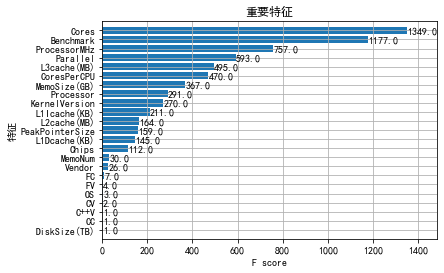

In [68]:
# 切分训练集和测试集
from sklearn.model_selection import train_test_split
import xgboost as xgb
train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=0.1,random_state=2022)

# xgboost模型初始化设置
dtrain=xgb.DMatrix(train_x,label=train_y,feature_names=list(X.columns))
dtest=xgb.DMatrix(test_x,label=test_y,feature_names=list(X.columns))
watchlist = [(dtrain,'train'),(dtest,'vaild')]

# booster:
params={'booster':'gbtree',
        'objective': 'reg:squaredlogerror',
        'eval_metric': 'rmse',
        'max_depth':9,
        'lambda':10,
        'subsample':0.75,
        'colsample_bytree':0.75,
        'min_child_weight':3,
        'eta': 0.025,
        'seed':0,
        'nthread':8,
        'gamma':0.15,
        'learning_rate' : 0.01,
       }

bst=xgb.train(params,dtrain,num_boost_round=10000,verbose_eval=200,evals=watchlist,early_stopping_rounds=100)
ypred=bst.predict(dtest)
 
ypred = bst.predict(dtest)
print("测试集每个样本的得分\n",ypred)
ypred_contribs = bst.predict(dtest, pred_contribs=True)
xgb.plot_importance(bst,height=0.8,title='重要特征', ylabel='特征')

In [69]:
np.exp(ypred),np.exp(test_y.values)

(array([260.23026 ,  11.75055 ,   6.175348, ...,  29.061481, 267.39474 ,
        415.4264  ], dtype=float32),
 array([244.  ,  12.5 ,   6.64, ...,  30.4 , 280.  , 381.  ]))

In [70]:
import pickle
# save model to file 模型保存
pickle.dump(bst, open("xgboost.pkl", "wb"))
 
# load model from file 模型加载
#bst = pickle.load(open("xgboost.pkl", "rb"))

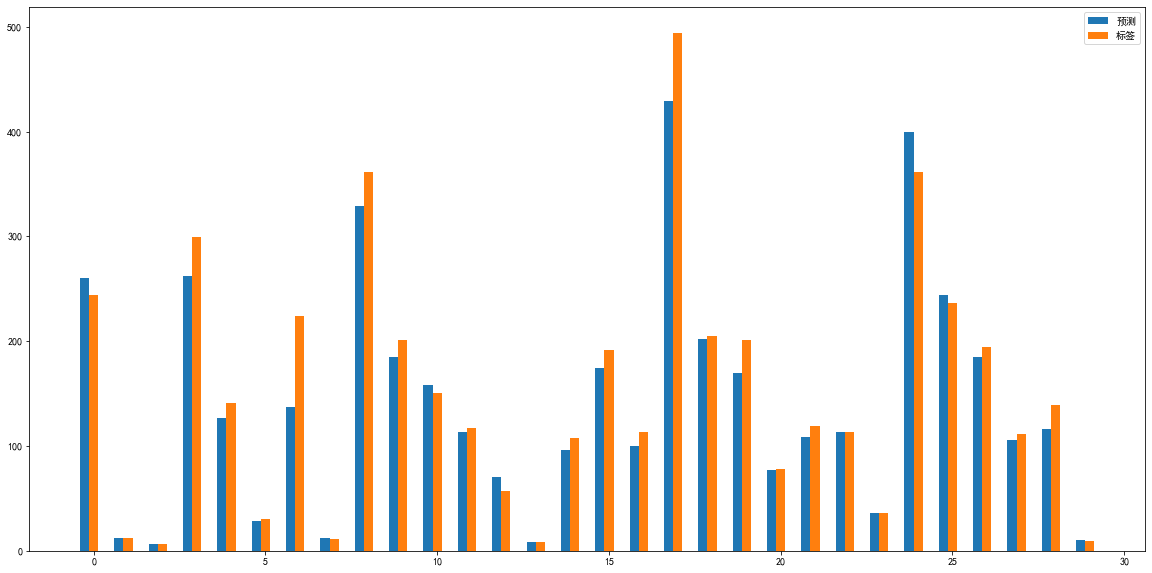

In [71]:
import numpy as np
import matplotlib.pyplot as plt

size = len(ypred[:30])
x = np.arange(size)
a = np.exp(ypred[:30])
b = np.exp(test_y[:30])

total_width, n = 0.8, 3
width = total_width / n
x = x - (total_width - width) / 2
plt.figure(figsize=(20,10))
plt.bar(x, a,  width=width, label='预测')
plt.bar(x + width, b, width=width, label='标签')
plt.legend()
plt.show()